In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1706708602000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv', name='clinicaltrial_2020.csv', size=46318151, modificationTime=1709374245000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.zip', name='clinicaltrial_2020.zip', size=10599182, modificationTime=1709372691000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1709374240000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.zip', name='clinicaltrial_2021.zip', size=11508457, modificationTime=1709372702000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.csv', name='clinicaltrial_2023.csv', size=292436366, modificationTime=1709374229000),
 FileInfo(path='dbfs:/FileStore/tables/clini

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col
from pyspark.sql.types import StructType, StructField, StringType

# Start Spark session
spark = SparkSession.builder.appName("clinical_trials").getOrCreate()

# Define the schema based on the provided fields
schema = StructType([
    StructField("Id", StringType(), True),
    StructField("Study Title", StringType(), True),
    StructField("Acronym", StringType(), True),
    StructField("Study Status", StringType(), True),
    StructField("Conditions", StringType(), True),
    StructField("Interventions", StringType(), True),
    StructField("Sponsor", StringType(), True),
    StructField("Collaborators", StringType(), True),
    StructField("Enrollment", StringType(), True),
    StructField("Funder Type", StringType(), True),
    StructField("Study Type", StringType(), True),
    StructField("Study Design", StringType(), True),
    StructField("Start Date", StringType(), True),
    StructField("Completion Date", StringType(), True)
])

# Load data as a single column of text
data_path = "/FileStore/tables/clinicaltrial_2023.csv"
df_raw = spark.read.text(data_path)

# Correctly split the "value" column by actual tab character
df_processed = df_raw.withColumn("value", split(col("value"), "\t"))

# Extract columns based on the schema
# Adjust the indexing if necessary to skip any header-like rows repeated in the data
df_final = df_processed.select([df_processed["value"].getItem(i).alias(field.name) for i, field in enumerate(schema.fields)])

df_filtered = df_final.filter(df_final["Id"] != "\"Id")
# Optionally, filter out the first row if it's a header or any non-data row
# Here, you would need a condition to identify such rows, like checking if "Id" matches a pattern

# Show the DataFrame to verify correct loading
df_filtered.show(5, truncate=False)


+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------------+------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------+------------------------------------------------------------------------------------+----------+-----------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id          |Study Title                                               

In [0]:
# adding "completion_date" column
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import date_format
df_filtered = df_filtered.withColumn('Completion Date', regexp_replace('Completion Date', '\"|,+', ''))

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql.functions import split, col

# Start Spark session
spark = SparkSession.builder.appName("pharmacy_dataset").getOrCreate()

# Define the schema based on the pharmacy dataset fields
schema = StructType([
    StructField("Company", StringType(), True),
    StructField("Parent_Company", StringType(), True),
    StructField("Penalty_Amount", IntegerType(), True),
    StructField("Subtraction_From_Penalty", IntegerType(), True),
    StructField("Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting", IntegerType(), True),
    StructField("Penalty_Year", IntegerType(), True),
    StructField("Penalty_Date", DateType(), True),
    StructField("Offense_Group", StringType(), True),
    StructField("Primary_Offense", StringType(), True),
    StructField("Secondary_Offense", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Level_of_Government", StringType(), True),
    StructField("Action_Type", StringType(), True),
    StructField("Agency", StringType(), True),
    StructField("Civil/Criminal", StringType(), True),
    StructField("Prosecution_Agreement", StringType(), True),
    StructField("Court", StringType(), True),
    StructField("Case_ID", StringType(), True),
    StructField("Private_Litigation_Case_Title", StringType(), True),
    StructField("Lawsuit_Resolution", StringType(), True),
    StructField("Facility_State", StringType(), True),
    StructField("City", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("Zip", StringType(), True),
    StructField("NAICS_Code", StringType(), True),
    StructField("NAICS_Translation", StringType(), True),
    StructField("HQ_Country_of_Parent", StringType(), True),
    StructField("HQ_State_of_Parent", StringType(), True),
    StructField("Ownership_Structure", StringType(), True),
    StructField("Parent_Company_Stock_Ticker", StringType(), True),
    StructField("Major_Industry_of_Parent", StringType(), True),
    StructField("Specific_Industry_of_Parent", StringType(), True),
    StructField("Info_Source", StringType(), True),
    StructField("Notes", StringType(), True)
])

# Assuming the delimiter is '|', update the path to your pharmacy dataset
data_path = "/FileStore/tables/pharma.csv"
df_pharmacy = spark.read.option("header", "true").csv(data_path, schema=schema, sep=",")
df_pharmacy.show(2)


+--------------------+-------------------+--------------+------------------------+---------------------------------------------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+--------------------+------------------+---------------------+-----+-------+-----------------------------+------------------+--------------+----+-------+----+----------+-----------------+--------------------+------------------+-------------------+---------------------------+------------------------+---------------------------+--------------------+-----+
|             Company|     Parent_Company|Penalty_Amount|Subtraction_From_Penalty|Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting|Penalty_Year|Penalty_Date|       Offense_Group|     Primary_Offense|   Secondary_Offense|         Description|Level_of_Government|  Action_Type|              Agency|    Civil/Criminal|Prosecution_Agreement|Court|Case_ID|

In [0]:
from pyspark.sql.functions import col, count, lit, when
from pyspark.sql.window import Window

# Function to calculate mode for a given column
def calculate_mode(df, column_name):
    # Group by the column, count occurrences, and order to find the mode
    mode_df = df.groupBy(column_name) \
                .agg(count(lit(1)).alias("freq")) \
                .orderBy(col("freq").desc())
    
    # Get the most frequent value (mode)
    mode_value = mode_df.first()[0]
    return mode_value

# Function to fill missing values with mode for each specified column
def fill_with_mode(df, columns):
    for column in columns:
        mode_value = calculate_mode(df.filter(col(column).isNotNull()), column)
        # Fill missing values in the DataFrame with the mode
        df = df.withColumn(column, when(col(column).isNull(), mode_value).otherwise(col(column)))
    return df

# Columns to fill with mode
columns_to_fill = ["Study Title", "Acronym", "Study Status", "Conditions", "Interventions", "Sponsor", "Collaborators", "Enrollment", "Funder Type", "Study Type", "Study Design", "Start Date"]

# Apply the function to fill missing values with mode
df_filtered = fill_with_mode(df_filtered, columns_to_fill)

# Show the DataFrame to verify that missing values are filled
df_filtered.show(5, truncate=False)


+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------------+------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------+------------------------------------------------------------------------------------+----------+-----------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id          |Study Title                                               

In [0]:
from pyspark.sql.functions import when, trim, col

# List of string columns to check for spaces and replace with "Unknown"
columns_to_fill = ["Study Title", "Acronym", "Study Status", "Conditions", "Interventions", "Sponsor", "Collaborators", "Enrollment", "Funder Type", "Study Type", "Study Design", "Start Date"] # Add other string columns as needed

for column in columns_to_fill:
    df_filtered = df_filtered.withColumn(column, when(trim(col(column)) == "", "Unknown").otherwise(col(column)))


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql.functions import split, col

# Start Spark session
spark = SparkSession.builder.appName("pharmacy_dataset").getOrCreate()

# Define the schema based on the pharmacy dataset fields
schema = StructType([
    StructField("Company", StringType(), True),
    StructField("Parent_Company", StringType(), True),
    StructField("Penalty_Amount", IntegerType(), True),
    StructField("Subtraction_From_Penalty", IntegerType(), True),
    StructField("Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting", IntegerType(), True),
    StructField("Penalty_Year", IntegerType(), True),
    StructField("Penalty_Date", DateType(), True),
    StructField("Offense_Group", StringType(), True),
    StructField("Primary_Offense", StringType(), True),
    StructField("Secondary_Offense", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Level_of_Government", StringType(), True),
    StructField("Action_Type", StringType(), True),
    StructField("Agency", StringType(), True),
    StructField("Civil/Criminal", StringType(), True),
    StructField("Prosecution_Agreement", StringType(), True),
    StructField("Court", StringType(), True),
    StructField("Case_ID", StringType(), True),
    StructField("Private_Litigation_Case_Title", StringType(), True),
    StructField("Lawsuit_Resolution", StringType(), True),
    StructField("Facility_State", StringType(), True),
    StructField("City", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("Zip", StringType(), True),
    StructField("NAICS_Code", StringType(), True),
    StructField("NAICS_Translation", StringType(), True),
    StructField("HQ_Country_of_Parent", StringType(), True),
    StructField("HQ_State_of_Parent", StringType(), True),
    StructField("Ownership_Structure", StringType(), True),
    StructField("Parent_Company_Stock_Ticker", StringType(), True),
    StructField("Major_Industry_of_Parent", StringType(), True),
    StructField("Specific_Industry_of_Parent", StringType(), True),
    StructField("Info_Source", StringType(), True),
    StructField("Notes", StringType(), True)
])

# Assuming the delimiter is '|', update the path to your pharmacy dataset
data_path = "/FileStore/tables/pharma.csv"
df_pharmacy = spark.read.option("header", "true").csv(data_path, schema=schema, sep=",")
df_pharmacy.show(2)


+--------------------+-------------------+--------------+------------------------+---------------------------------------------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+--------------------+------------------+---------------------+-----+-------+-----------------------------+------------------+--------------+----+-------+----+----------+-----------------+--------------------+------------------+-------------------+---------------------------+------------------------+---------------------------+--------------------+-----+
|             Company|     Parent_Company|Penalty_Amount|Subtraction_From_Penalty|Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting|Penalty_Year|Penalty_Date|       Offense_Group|     Primary_Offense|   Secondary_Offense|         Description|Level_of_Government|  Action_Type|              Agency|    Civil/Criminal|Prosecution_Agreement|Court|Case_ID|

In [0]:
string_columns = [field.name for field in schema.fields if isinstance(field.dataType, StringType)]

for column in string_columns:
    df_pharmacy = df_pharmacy.na.fill({column: "Unknown"})


In [0]:
integer_columns = [field.name for field in schema.fields if isinstance(field.dataType, IntegerType)]

for column in integer_columns:
    df_pharmacy = df_pharmacy.na.fill({column: 0})


In [0]:
#Question 1: Number of Studies in the dataset
distinct_studies = df_filtered.select("Id").distinct().count()
distinct_studies

Out[9]: 483422

In [0]:
#Question 2: Types of studies and their frequencies
study_type_freq = df_filtered.groupBy("Study Type").count().orderBy("count", ascending=False)
study_type_freq.show()


+---------------+------+
|     Study Type| count|
+---------------+------+
| INTERVENTIONAL|371384|
|  OBSERVATIONAL|110221|
|EXPANDED_ACCESS|   928|
|        Unknown|   889|
+---------------+------+



In [0]:
#Question 3: Top 5 conditions with frequencies
from pyspark.sql.functions import desc

# Correct the aggregation and ordering for conditions
top_conditions = df_filtered.groupBy("Conditions").count().orderBy(desc("count")).limit(5)

# Show the results
top_conditions.show(truncate=False)


+---------------+-----+
|Conditions     |count|
+---------------+-----+
|Healthy        |7997 |
|Breast Cancer  |4556 |
|Prostate Cancer|2650 |
|Asthma         |2309 |
|Obesity        |2284 |
+---------------+-----+



In [0]:
#Question 4: Top 10 most common sponsors that are not phramaceutical 
from pyspark.sql.functions import desc
non_pharma_sponsors = (df_filtered.join(df_pharmacy, df_filtered.Sponsor == df_pharmacy.Company, "left_anti")
                        .groupBy("Sponsor")
                        .count()
                        .orderBy(desc("count"))  # Correct ordering syntax
                        .limit(10))

non_pharma_sponsors.show()


+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3410|
|   Assiut University| 3335|
|    Cairo University| 3023|
|Assistance Publiq...| 2951|
|         Mayo Clinic| 2766|
|M.D. Anderson Can...| 2702|
|National Institut...| 2340|
|Massachusetts Gen...| 2263|
|National Taiwan U...| 2181|
|   Hoffmann-La Roche| 1978|
+--------------------+-----+



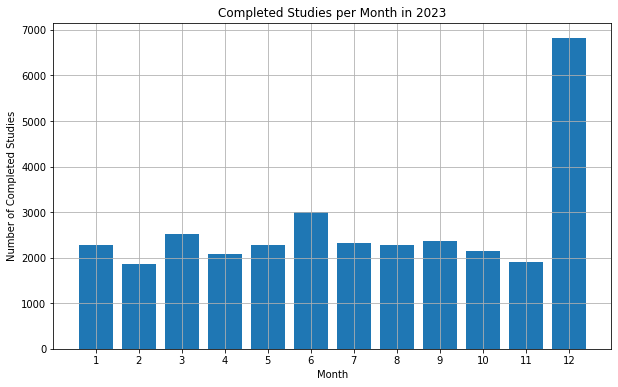

,month,count
0,1,2285
1,2,1861
2,3,2523
3,4,2081
4,5,2286
5,6,3003
6,7,2329
7,8,2281
8,9,2356
9,10,2144


In [0]:
#Question 5: Completed number of studies in 2023 
from pyspark.sql.functions import to_date, year, month
import matplotlib.pyplot as plt

df_filtered = df_filtered.withColumn("Completion Date", to_date(df_filtered["Completion Date"], "yyyy-MM-dd"))

# Now filter for 2023 and group by month
completed_studies_df = df_filtered.filter(year("Completion Date") == 2023) \
                                  .groupby(month("Completion Date").alias('month')) \
                                  .count().orderBy('month')

# Convert to Pandas DataFrame for plotting
completed_studies_pd = completed_studies_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(completed_studies_pd['month'], completed_studies_pd['count'])
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.title('Completed Studies per Month in 2023')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

# Display table of values
completed_studies_pd

In [0]:
#further analysis 
from pyspark.sql.functions import year, to_date

df_filtered.withColumn("start_year", year(to_date("Start Date", "yyyy-MM-dd"))) \
    .groupBy("start_year") \
    .count() \
    .orderBy("start_year") \
    .show()


+----------+------+
|start_year| count|
+----------+------+
|      null|219840|
|      1916|     1|
|      1917|     1|
|      1963|     1|
|      1968|     1|
|      1972|     1|
|      1973|     2|
|      1975|     1|
|      1976|     5|
|      1977|     8|
|      1978|     2|
|      1979|     4|
|      1980|     2|
|      1981|     2|
|      1983|     5|
|      1984|    10|
|      1985|     4|
|      1986|     2|
|      1987|     3|
|      1988|     7|
+----------+------+
only showing top 20 rows



In [0]:
#further analysis 
df_filtered.filter(df_filtered["Collaborators"].isNotNull()) \
    .groupBy("Collaborators") \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .show()


+--------------------+------+
|       Collaborators| count|
+--------------------+------+
|             Unknown|325505|
|National Cancer I...|  7918|
|National Heart", ...|  1689|
|National Institut...|  1590|
|National Institut...|  1394|
+--------------------+------+

